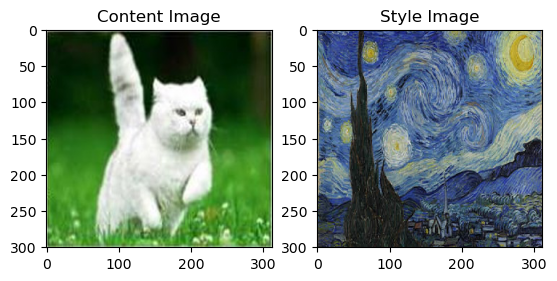

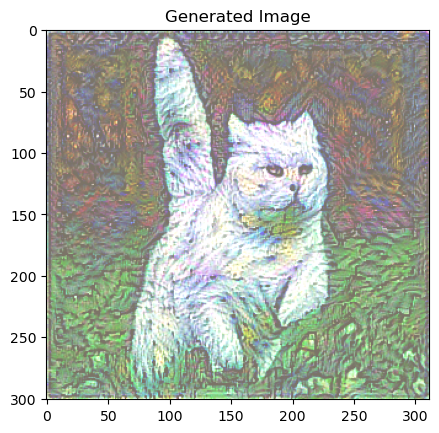

In [6]:
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.applications import vgg19 
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt 
 
# Define paths to content and style images 
content_path = "content_image.jpg" 
style_path = "style_image (1).jpg" 
 
# Define image dimensions 
width, height = load_img(content_path).size 
img_size = (height, width) 
 
# Load and preprocess images 
def load_and_preprocess_image(path): 
    img = load_img(path, target_size=img_size) 
    img = img_to_array(img) 
    img = np.expand_dims(img, axis=0) 
    img = vgg19.preprocess_input(img) 
    return img 
 
# De-process and display the generated image 
def deprocess_img(processed_img): 
    x = processed_img.copy() 
    if len(x.shape) == 4: 
        x = np.squeeze(x, 0) 
    x[:, :, 0] += 103.939 
    x[:, :, 1] += 116.779 
    x[:, :, 2] += 123.68 
    x = x[:, :, ::-1] 
    x = np.clip(x, 0, 255).astype('uint8') 
    return x 
 
# Load and preprocess content and style images 
content_image = load_and_preprocess_image(content_path) 
style_image = load_and_preprocess_image(style_path) 
 
# Display content and style images 
plt.subplot(1, 2, 1) 
plt.imshow(deprocess_img(content_image)) 
plt.title('Content Image') 
 
plt.subplot(1, 2, 2) 
plt.imshow(deprocess_img(style_image)) 
plt.title('Style Image') 
 
plt.show() 
 
# Define a VGG19 model for feature extraction 
vgg = vgg19.VGG19(include_top=False, weights='imagenet') 
vgg.trainable = False 
 
# Get the outputs from intermediate layers 
content_layers = ['block5_conv2'] 
style_layers = [ 
    'block1_conv1', 
    'block2_conv1', 
    'block3_conv1', 
    'block4_conv1', 
    'block5_conv1', 
] 
 
content_outputs = [vgg.get_layer(name).output for name in content_layers] 
style_outputs = [vgg.get_layer(name).output for name in style_layers] 
model_outputs = content_outputs + style_outputs 
 
# Build model 
model = Model(inputs=vgg.input, outputs=model_outputs) 
 
# Calculate content and style representations 
def get_feature_representations(model, content_path, style_path): 
    content_image = load_and_preprocess_image(content_path) 
    style_image = load_and_preprocess_image(style_path) 
 
    content_outputs = model(content_image) 
    style_outputs = model(style_image) 
 
    content_features = [layer[0] for layer in content_outputs[:len(content_layers)]] 
     
    # Ensure style features have the same shape as content features 
    style_features = [tf.expand_dims(layer[0], axis=0) for layer in style_outputs[len(content_layers):]] 
 
    return content_features, style_features 
 
content_features, style_features = get_feature_representations(model, content_path, style_path) 
 
# Define and build the Gram matrix 
def gram_matrix(input_tensor): 
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 
    input_shape = tf.shape(input_tensor) 
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32) 
    return result / num_locations 
 
# Define the style loss function 
def style_loss(style, generated): 
    style_gram = gram_matrix(style) 
    generated_gram = gram_matrix(generated) 
    return tf.reduce_mean(tf.square(style_gram - generated_gram)) 
 
# Define the content loss function 
def content_loss(content, generated): 
    return tf.reduce_mean(tf.square(content - generated)) 
 
# Define total variation loss 
def total_variation_loss(image): 
    x_var = tf.square(image[:, :-1, :-1, :] - image[:, 1:, :-1, :]) 
    y_var = tf.square(image[:, :-1, :-1, :] - image[:, :-1, 1:, :]) 
    return tf.reduce_mean(x_var + y_var) 
 
# Define weights for content, style, and total variation loss 
content_weight = 1e3 
style_weight = 1e-2 
total_variation_weight = 30 
 
# Define optimizer 
optimizer = tf.optimizers.Adam(learning_rate=0.5, beta_1=0.99, epsilon=1e-1) 
 
# Generate the target image with neural style transfer 
target_image = tf.Variable(content_image, dtype=tf.float32) 
 
@tf.function() 
def train_step(image): 
    with tf.GradientTape() as tape: 
        outputs = model(image) 
        content_loss_val = 0 
        style_loss_val = 0 
 
        content_features_gen = outputs[:len(content_layers)] 
        style_features_gen = outputs[len(content_layers):] 
 
        for c, c_gen in zip(content_features, content_features_gen): 
            content_loss_val += content_loss(c, c_gen) 
 
        for s, s_gen in zip(style_features, style_features_gen): 
            style_loss_val += style_loss(s, s_gen) 
 
        content_loss_val *= content_weight / len(content_layers) 
        style_loss_val *= style_weight / len(style_layers) 
 
        total_variation_loss_val = total_variation_loss(image) * total_variation_weight 
 
        total_loss = content_loss_val + style_loss_val + total_variation_loss_val 
 
    grad = tape.gradient(total_loss, image) 
    optimizer.apply_gradients([(grad, image)]) 
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)) 
 
# Number of optimization steps 
num_iterations =  500
 
# Optimization loop 
for i in range(num_iterations): 
    train_step(target_image) 
 
# Display the final generated image 
plt.imshow(deprocess_img(target_image.numpy())) 
plt.title('Generated Image') 
plt.show()

In [ ]:
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.applications import vgg19 
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt 

# Define paths to content and style images 
content_path = "content_image.jpg"  # Path to the content image
style_path = "style_image (1).jpg"  # Path to the style image

# Define image dimensions 
width, height = load_img(content_path).size  # Get the size of the content image
img_size = (height, width)  # Set target image size for both content and style images

# Function to load and preprocess images 
def load_and_preprocess_image(path): 
    img = load_img(path, target_size=img_size)  # Load image and resize it to img_size
    img = img_to_array(img)  # Convert image to numpy array
    img = np.expand_dims(img, axis=0)  # Add batch dimension (for batch processing)
    img = vgg19.preprocess_input(img)  # Preprocess the image as required by VGG19 model
    return img 

# Function to de-process and display the generated image 
def deprocess_img(processed_img): 
    x = processed_img.copy() 
    if len(x.shape) == 4:  # Remove the batch dimension
        x = np.squeeze(x, 0) 
    x[:, :, 0] += 103.939  # Revert the preprocessing step (add the mean value for each channel)
    x[:, :, 1] += 116.779 
    x[:, :, 2] += 123.68 
    x = x[:, :, ::-1]  # Convert from RGB to BGR
    x = np.clip(x, 0, 255).astype('uint8')  # Clip values to valid range and convert to uint8
    return x 

# Load and preprocess content and style images 
content_image = load_and_preprocess_image(content_path) 
style_image = load_and_preprocess_image(style_path) 

# Display content and style images 
plt.subplot(1, 2, 1) 
plt.imshow(deprocess_img(content_image)) 
plt.title('Content Image') 

plt.subplot(1, 2, 2) 
plt.imshow(deprocess_img(style_image)) 
plt.title('Style Image') 

plt.show() 

# Define a VGG19 model for feature extraction 
vgg = vgg19.VGG19(include_top=False, weights='imagenet')  # Load VGG19 without the fully connected layers
vgg.trainable = False  # Freeze the VGG19 model as we are using it for feature extraction only

# Define the content and style layers for extracting features
content_layers = ['block5_conv2']  # Layer where content features will be extracted from
style_layers = [ 
    'block1_conv1', 
    'block2_conv1', 
    'block3_conv1', 
    'block4_conv1', 
    'block5_conv1', 
] 

# Extract outputs from the defined layers
content_outputs = [vgg.get_layer(name).output for name in content_layers] 
style_outputs = [vgg.get_layer(name).output for name in style_layers] 
model_outputs = content_outputs + style_outputs  # Combine content and style outputs

# Build model for feature extraction
model = Model(inputs=vgg.input, outputs=model_outputs) 

# Function to calculate content and style feature representations
def get_feature_representations(model, content_path, style_path): 
    content_image = load_and_preprocess_image(content_path) 
    style_image = load_and_preprocess_image(style_path) 

    content_outputs = model(content_image)  # Extract features for content image
    style_outputs = model(style_image)  # Extract features for style image

    content_features = [layer[0] for layer in content_outputs[:len(content_layers)]]  # Get content features
    
    # Ensure style features have the same shape as content features
    style_features = [tf.expand_dims(layer[0], axis=0) for layer in style_outputs[len(content_layers):]] 

    return content_features, style_features 

# Get content and style feature representations
content_features, style_features = get_feature_representations(model, content_path, style_path) 

# Function to compute the Gram matrix
def gram_matrix(input_tensor): 
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)  # Matrix multiplication to compute the Gram matrix
    input_shape = tf.shape(input_tensor) 
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)  # Calculate the number of locations (pixels)
    return result / num_locations  # Normalize by the number of pixels

# Function to compute the style loss
def style_loss(style, generated): 
    style_gram = gram_matrix(style)  # Compute the Gram matrix for the style image
    generated_gram = gram_matrix(generated)  # Compute the Gram matrix for the generated image
    return tf.reduce_mean(tf.square(style_gram - generated_gram))  # Compute the squared difference between style and generated Gram matrices

# Function to compute the content loss
def content_loss(content, generated): 
    return tf.reduce_mean(tf.square(content - generated))  # Compute the squared difference between content and generated features

# Function to compute total variation loss to reduce artifacts
def total_variation_loss(image): 
    x_var = tf.square(image[:, :-1, :-1, :] - image[:, 1:, :-1, :])  # Difference between adjacent pixels in x-direction
    y_var = tf.square(image[:, :-1, :-1, :] - image[:, :-1, 1:, :])  # Difference between adjacent pixels in y-direction
    return tf.reduce_mean(x_var + y_var)  # Sum the variations and compute the mean

# Weights for the losses to balance content, style, and total variation
content_weight = 1e3  # Higher value gives more importance to content preservation
style_weight = 1e-2  # Lower value gives more importance to style preservation
total_variation_weight = 30  # Weight for the total variation loss

# Define optimizer (Adam optimizer for training the image)
optimizer = tf.optimizers.Adam(learning_rate=0.5, beta_1=0.99, epsilon=1e-1) 

# Create a tensor variable for the target image to optimize
target_image = tf.Variable(content_image, dtype=tf.float32) 

@tf.function() 
def train_step(image): 
    with tf.GradientTape() as tape:  # Watch the image tensor for gradients
        outputs = model(image)  # Get the feature outputs for the current image
        content_loss_val = 0  # Initialize content loss
        style_loss_val = 0  # Initialize style loss

        content_features_gen = outputs[:len(content_layers)]  # Extract content features for generated image
        style_features_gen = outputs[len(content_layers):]  # Extract style features for generated image

        # Compute the content loss for each layer
        for c, c_gen in zip(content_features, content_features_gen): 
            content_loss_val += content_loss(c, c_gen)

        # Compute the style loss for each layer
        for s, s_gen in zip(style_features, style_features_gen): 
            style_loss_val += style_loss(s, s_gen)

        # Scale content and style losses
        content_loss_val *= content_weight / len(content_layers) 
        style_loss_val *= style_weight / len(style_layers) 

        # Compute total variation loss
        total_variation_loss_val = total_variation_loss(image) * total_variation_weight 

        # Total loss is a combination of content, style, and total variation loss
        total_loss = content_loss_val + style_loss_val + total_variation_loss_val 

    # Compute gradients and apply them to the image
    grad = tape.gradient(total_loss, image) 
    optimizer.apply_gradients([(grad, image)]) 
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0))  # Clip values to ensure valid pixel range

# Number of optimization steps to generate the image
num_iterations = 500

# Optimization loop
for i in range(num_iterations): 
    train_step(target_image)  # Perform a training step (optimize the image)

# Display the final generated image
plt.imshow(deprocess_img(target_image.numpy()))  # De-process the image and display it
plt.title('Generated Image')  # Title of the generated image
plt.show()


In [ ]:
Explanation of the Workflow:
Image Preprocessing:

The images are loaded and preprocessed (resized and normalized) to fit into the VGG19 model.

Feature Extraction:

The content and style images are processed through the VGG19 network, and specific layers are chosen for extracting features (content and style).

Gram Matrix:

The Gram matrix is used to compute the correlation between feature maps of the style image. It helps in calculating the style loss.

Loss Functions:

Content Loss: Measures the difference between the content of the generated image and the content image.

Style Loss: Measures the difference between the style of the generated image and the style image using the Gram matrix.

Total Variation Loss: Reduces noise and encourages spatial coherence.

Optimization:

The Adam optimizer is used to minimize the total loss, which is a combination of content, style, and total variation losses.

Training Loop:

The loop runs for 500 iterations (can be adjusted), optimizing the generated image to match the content and style of the target images.

Output:
After running the code, you should see the generated image which is a blend of the content image and the style image. You can adjust the weights to control how much influence each image (content and style) has on the final result.